# Analysis workbook for Pd-catalyzed decarbonylative Suzuki-Miyaura coupling

Code for plotting is in `multicat-data/manuscript_figures`.

In [18]:
# running utility functions and base settings
%run '../viz_fns.ipynb'

## Processing simulation data

In this section we visualize a sample landscape, then execute the simulation analysis workflow: we select the top $ (k,t,r) $ parameters for each landscape, perform statistical analysis on the best accuracy/efficiency metrics, etc.

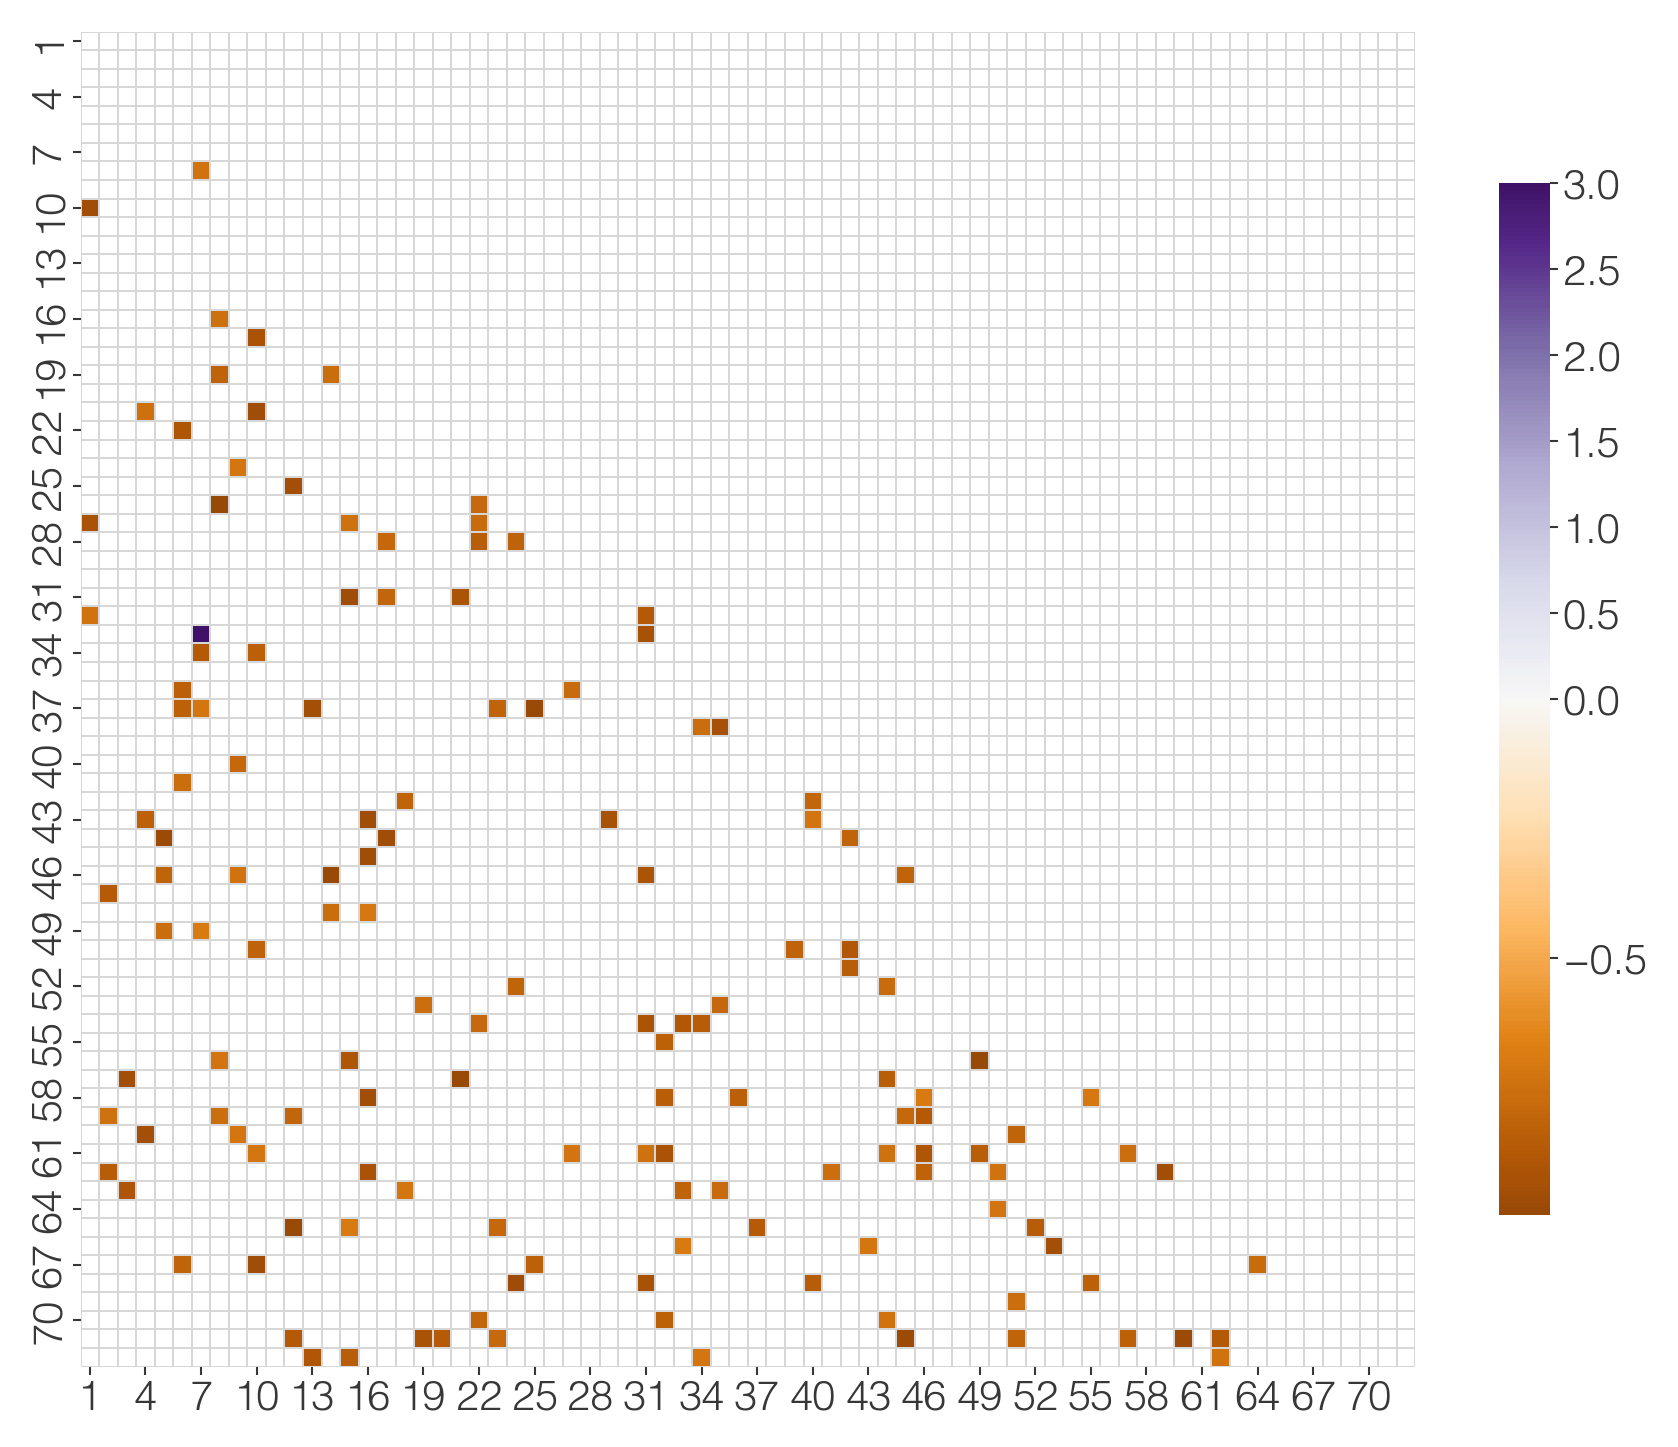

In [6]:
f = '/n/home10/msak/multicat-data/Pd_coupling/simulation/ls/72_merck_batch_2_3_8_ls_2_coop_mat.csv'

viz_coop_zero_center(72, f, simple=False)

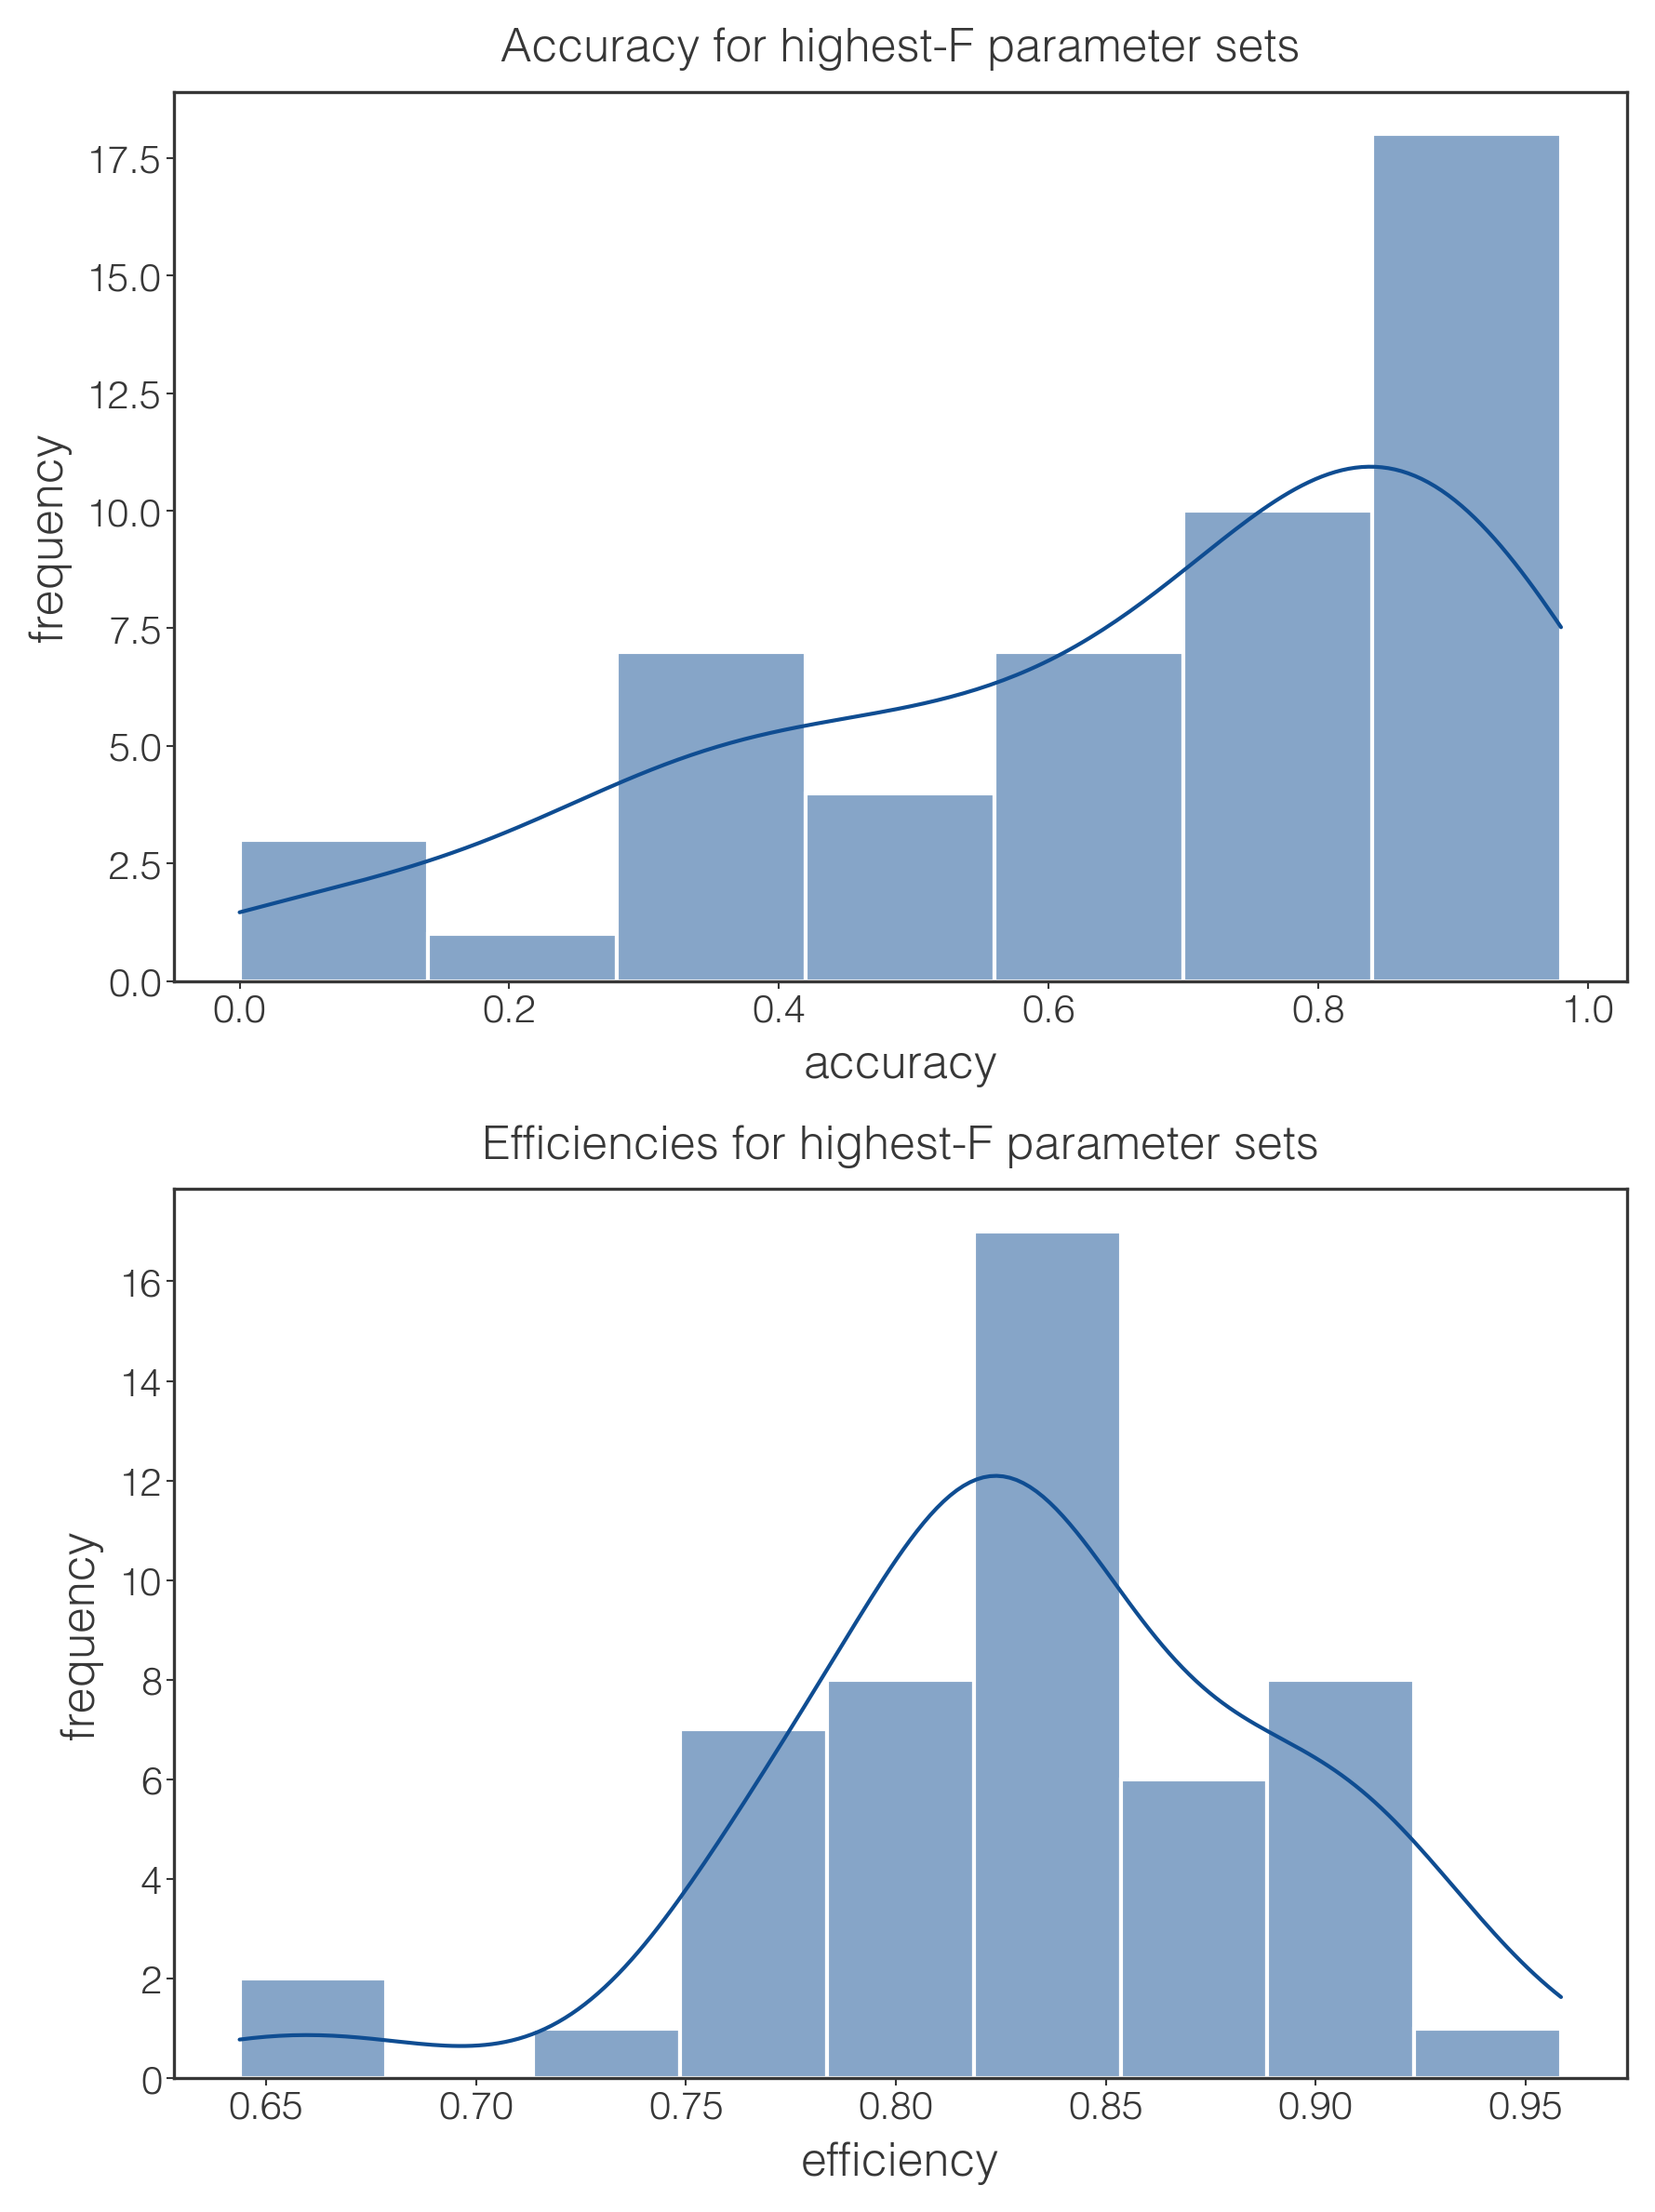

Parameter report saved to ./simulation/top_params.csv


(0.6512, 0.8320831768388106)

In [5]:
viz_batch_optim('./simulation/out/*out.csv', N=72, beta=1, viz_dist=True, report_params='./simulation/top_params.csv')

## Ligand selection

We define our target set of mono- and bidentate ligands to contain 64 and 32 ligands respectively.

The code in this section closely reproduces previously published code, citation follows:

The file "descriptors.xlsx" with the phosphorus ligand descriptors can be found in the supporting information of the original kraken publication:
https://pubs.acs.org/doi/suppl/10.1021/jacs.1c09718/suppl_file/ja1c09718_si_002.zip. In this repository it can be found in `multicat-data/Pd_coupling/ligand_selection/kraken_descriptors.xlsx`

We have cited this paper:

Gensch, T.; dos Passos Gomes, G.; Friederich, P.; Peters, E.; Gaudin, T.; Pollice, R.; Jorner, K.; Nigam, A.; Lindner-D’Addario, M.; Sigman, M. S.; Aspuru-Guzik, A. 
A Comprehensive Discovery Platform for Organophosphorus Ligands for Catalysis. 
J. Am. Chem. Soc. 2022, 144 (3), 1205–1217. 
https://doi.org/10.1021/jacs.1c09718

In [7]:
from sklearn.cluster import KMeans

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

import itertools
from rdkit import DataStructs

import sys
import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize) #print out full arrays

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

randomstate = 42

In [8]:
colors32 = ['#000000', '#222034', '#45283c', '#663931', '#8f563b', '#df7126', '#d9a066', '#eec39a', '#fbf236', '#99e550', '#6abe30', '#37946e', '#4b692f', '#524b24', '#323c39', '#3f3f74', '#306082', '#5b6ee1', '#639bff', '#5fcde4', '#cbdbfc', '#dddddd', '#9badb7', '#847e87', '#696a6a', '#595652', '#76428a', '#ac3232', '#d95763', '#d77bba', '#8f974a', '#8a6f30']

colors64 = [
    '#000000', '#1D2B53', '#7E2553', '#008751', '#AB5236', '#5F574F', '#C2C3C7', '#FFF1E8',
    '#FF004D', '#FFA300', '#FFEC27', '#00E436', '#29ADFF', '#83769C', '#FF77A8', '#FFCCAA',
    '#291814', '#111D35', '#422136', '#125359', '#742F29', '#49333B', '#A28879', '#F3EF7D',
    '#BE1250', '#FF6C24', '#A8E72E', '#00B543', '#065AB5', '#754665', '#FF6E59', '#FF9D81',
    '#4D2F3C', '#323C54', '#5E3643', '#0F595E', '#8A3F36', '#6A4F4B', '#8B8C8E', '#E8D0A9',
    '#FF3372', '#FFB037', '#F5EC59', '#46E553', '#50C5E8', '#9A7EC7', '#FF98C3', '#FFDAB9',
    '#2E1A1E', '#233658', '#5B3138', '#1B6D71', '#A04940', '#5F5A57', '#B2B3B6', '#F4E9C8',
    '#D6336C', '#FF9000', '#FFDC00', '#2ECC71', '#3498DB', '#9B59B6', '#FF69B4', '#FFE4B5'
]

def mol_to_img_df(row):
    mol = Chem.MolFromSmiles(row["smiles"])
    return(Draw.MolToImage(mol))

def dist_to_center(line):
    delta = line[use_cols] - kmeans.cluster_centers_[int(line["cluster"])]
    dist = np.linalg.norm(delta)
    return(dist)

In [9]:
features = pd.read_excel("./ligand_selection/kraken_descriptors.xlsx", sheet_name="reduced_features_DFT", 
                         index_col = 0)
filters = pd.read_csv("./ligand_selection/phoss_filters.csv", index_col = 0)
#use_rows = features.index # use this if no filtering is applied

criterion1 = set(filters.loc[filters["com"] == 1].index)
use_rows = sorted(criterion1)
print(f"Keeping {len(use_rows)} compounds.")

Keeping 495 compounds.


### monodentate ligands

In [10]:
# How many clusters to generate:
nclusters = 64

# Which feature space to use for the clustering: PCA/umap
use_space = "PCA" 

find_cols = {"PCA": ["PC1","PC2","PC3","PC4"],
             "umap": ["umap1","umap2"],}

use_cols = find_cols[use_space]
X_kmeans = features.loc[use_rows,use_cols]
display(X_kmeans)
kmeans = KMeans(n_clusters=nclusters, random_state=1).fit(X_kmeans)
data_df = features.loc[use_rows].copy()
display(data_df)

data_df["closest_to_center"] = 0
data_df["cluster"] = kmeans.labels_
data_df["distance_to_center"] = data_df.apply(dist_to_center, axis = 1)
clustermins = []
for clusternumber in range(nclusters):
    min_to_center_idx = data_df[data_df["cluster"] == clusternumber]["distance_to_center"].idxmin()
    clustermins.append(min_to_center_idx)
    data_df.loc[min_to_center_idx,"closest_to_center"] = 1

print(clustermins)

,PC1,PC2,PC3,PC4
ID,,,,
1,11.256186,-0.657241,7.758946,-3.247701
2,8.845686,0.595407,6.739153,-2.817894
3,7.116978,0.838970,5.035702,-2.497649
4,10.818188,-1.557446,7.481010,-3.170921
5,5.141353,1.328914,6.591504,-2.483875
...,...,...,...,...
1815,1.057174,-7.070141,8.696981,1.173450
1900,15.083140,2.928049,2.215226,2.120323
1901,10.930897,-2.805867,0.383447,-2.581221


,smiles,PC1,PC2,PC3,PC4,umap1,umap2
ID,,,,,,,
1,CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2...,11.256186,-0.657241,7.758946,-3.247701,8.318198,4.733678
2,CN(C)c1cccc(N(C)C)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1,8.845686,0.595407,6.739153,-2.817894,8.365421,4.867214
3,COc1cccc(OC)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1,7.116978,0.838970,5.035702,-2.497649,8.296419,4.997310
4,CC(C)Oc1cccc(OC(C)C)c1-c1ccccc1P(C1CCCCC1)C1CC...,10.818188,-1.557446,7.481010,-3.170921,8.531631,4.877754
5,c1ccc(-c2ccccc2P(C2CCCCC2)C2CCCCC2)cc1,5.141353,1.328914,6.591504,-2.483875,8.091322,5.610940
...,...,...,...,...,...,...,...
1815,CCCCSP(SCCCC)SCCCC,1.057174,-7.070141,8.696981,1.173450,4.970938,6.883710
1900,COc1ccc(OC)c(P2C(C)(C)CC3(CC2(C)C)OCCO3)c1-c1c...,15.083140,2.928049,2.215226,2.120323,7.582374,4.452136
1901,COc1ccc(-c2c(OC)ccc3ccccc23)c(OC)c1P(C1CCCCC1)...,10.930897,-2.805867,0.383447,-2.581221,8.994990,4.762981


[280, 233, 141, 439, 245, 148, 302, 1900, 77, 694, 242, 240, 243, 318, 521, 276, 795, 445, 477, 723, 641, 12, 873, 446, 54, 66, 440, 652, 734, 154, 338, 239, 728, 25, 401, 710, 369, 285, 292, 1, 274, 149, 1299, 1297, 514, 237, 314, 673, 254, 364, 216, 687, 366, 251, 534, 358, 125, 511, 681, 259, 540, 698, 310, 300]


ID
300                                                      CCOC(=O)c1ccc(P(c2ccccc2)c2ccccc2)cc1
16                                   FC(F)(F)c1ccc(P(c2ccc(C(F)(F)F)cc2)c2ccc(C(F)(F)F)cc2)cc1
489                                                    O=S(=O)(O)c1cccc(P(c2ccccc2)c2ccccc2)c1
797                                    O=C(O)c1ccc(P(c2ccc(C(F)(F)F)cc2)c2ccc(C(F)(F)F)cc2)cc1
608                                                 Cc1cc(C)cc(P(c2cc(C)cc(C)c2)c2ccccc2C=O)c1
232    FC(F)(F)c1cc(P(c2cc(C(F)(F)F)cc(C(F)(F)F)c2)c2cc(C(F)(F)F)cc(C(F)(F)F)c2)cc(C(F)(F)F)c1
798                                      O=C(O)c1ccc(P(c2ccc(C(=O)O)cc2)c2ccc(C(F)(F)F)cc2)cc1
115                                                           N#Cc1ccc(P(c2ccccc2)c2ccccc2)cc1
455                                           CN(C)c1ccc(P(c2ccc(N(C)C)cc2)c2ccc(N(C)C)cc2)cc1
Name: smiles, dtype: object


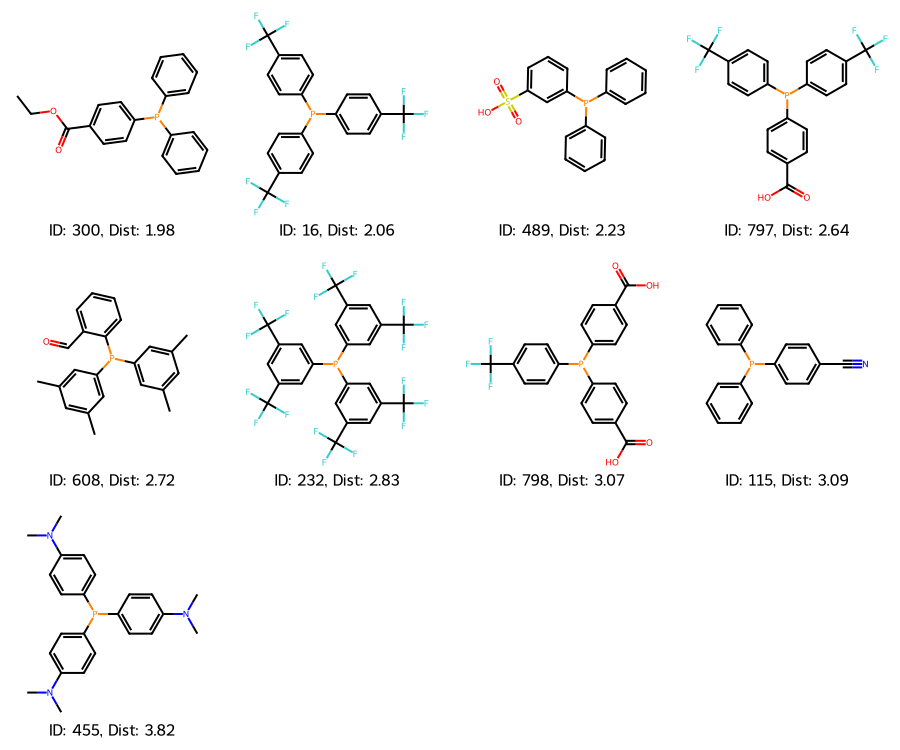

In [11]:
pd.set_option('display.max_colwidth', None)
show_n_mols = 10    # Show up to N molecules nearest to the cluster center
cluster_select = 63 # which cluster to inspect

def generate_molimg(show_n_mols,clusters_select):
    show_n_mols = int(show_n_mols)
    clustermin_idx = clustermins[clusters_select]
    
    sorted_mols = data_df.loc[data_df["cluster"] == clusters_select].sort_values(by="distance_to_center")
    showno = min(show_n_mols,len(sorted_mols))
    show_idxs = sorted_mols.iloc[:showno].index
    smilesobs = sorted_mols.loc[show_idxs,"smiles"]
    print(smilesobs)
    molobs = [Chem.MolFromSmiles(i) for i in smilesobs]
    legends = [f"ID: {i}, Dist: {data_df.loc[i,'distance_to_center']:.2f}" for i in show_idxs]
    img_src = Draw.MolsToGridImage(molobs, subImgSize=(225,250), molsPerRow=4,
                                  legends = legends)
    
    return(img_src)

generate_molimg(show_n_mols,cluster_select)

We manually inspect each cluster and select ligands, starting from the one closest to the centroid, that are available for purchase from reputable vendors. The compiled list of monodentate ligands is available at `multicat-data/Pd_coupling/ligand_selection/monodentate_curated_scifinder.csv`. 

### bidentate ligands 

We follow the procedure reported by Mack, Sigman, and coworkers: J. Am. Chem. Soc. 2023, 145, 1, 110–121 (https://doi.org/10.1021/jacs.2c08513). The file containing descriptors for bidentate ligands can be found at `multicat-data/ligand_selection/bident_params.csv`

In [12]:
# Define the parameters to use in the electronic, steric and geometric axis.
D1_name, D2_name, D3_name = 'electronic', 'steric', 'geometric'
idx = ['id']
D1_params = ['x12', 'x128', 'x168', 'x121', 'x122', 'x112', 'x38', 'x169','x171'] 
D2_params = ['x142', 'x143', 'x148', 'x149']
D3_params = ['x69', 'x172']

features = pd.read_csv('./ligand_selection/bident_params.csv')

# Removes ligand names and parameter names. 
# removes enantiomer parameters
features = features[~features['id'].astype(str).str.contains('_1')]
features = features.set_index('id')
features.index = features.index.astype(int)
display(features)
#features = features.reset_index(drop=True)

ligand_ids = list(features.index)  # Ligand ids after curation

# Create condensed dataframe with parameters selected for D1, D2, and D3
cond_features = features[D1_params + D2_params + D3_params]

,name,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x172,x173,x174,x175,x176,x177,x178,x179,x180,x181
id,,,,,,,,,,,,,,,,,,,,,
8,RR_DIOP,-0.373830,-0.346740,-0.362805,-0.75008,-0.72556,-0.737820,244.4647,265.2184,254.84155,...,97.362435,-0.19741,-0.03598,1.4598,453.32,54.371834,54.595463,51.852078,45.412264,36.538429
10,SS_Et_Duphos,-0.512990,-0.478000,-0.490163,-0.34514,-0.34379,-0.344465,183.0535,189.8291,186.44130,...,88.758311,-0.17599,-0.03111,1.7517,342.79,57.540599,59.592437,56.425018,47.141594,33.130269
12,W001,-0.372250,-0.329250,-0.347915,-0.49678,-0.33308,-0.414930,211.7585,241.2173,226.48790,...,98.393806,-0.21170,-0.07060,4.0668,624.49,62.135913,63.715008,61.635158,56.091773,47.585433
14,M003-1,-0.355940,-0.330160,-0.343077,-0.38822,-0.38294,-0.385580,226.1883,235.2270,230.70765,...,102.395428,-0.23134,-0.08159,4.0201,795.29,57.826468,58.316523,58.162586,57.212799,54.091570
16,W005-1,-0.374740,-0.328500,-0.350253,-0.49465,-0.32810,-0.411375,214.5602,239.3335,226.94685,...,97.091120,-0.20083,-0.07033,3.1133,716.98,63.706794,65.046785,63.394997,57.937888,50.120259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,TetraBenzoOxacyclononane,-0.357080,-0.344420,-0.348787,-0.39347,-0.37426,-0.383865,238.7059,239.9219,239.31390,...,101.478832,-0.19757,-0.03958,1.8774,618.11,55.031101,55.374434,52.503469,48.783618,41.950425
822,TetraBenzoOxocane,-0.361870,-0.346400,-0.352247,-0.39394,-0.37893,-0.386435,238.3393,246.3716,242.35545,...,95.778528,-0.19549,-0.05716,2.2004,617.58,55.245270,55.406632,51.768905,47.224817,40.047278
823,ThiXantPhos,-0.359330,-0.310850,-0.340803,-0.36357,-0.35811,-0.360840,256.2900,258.5121,257.40105,...,101.477814,-0.20195,-0.04029,2.9641,551.46,53.521678,54.605161,51.544220,46.505510,38.985373


We then perform PCA on each of the three types of params (steric, geometric, electronic). We take PC1 and PC2 from each to define a 6D chemical space, from which we sample 32 representative ligands. With 617 ligands and their six coeffs in PCA space, we form 32 clusters with KMeans as before.

In [13]:
n_pcs = 2 # Number of principle components

# Scale the condensed data 
scaler = StandardScaler().fit(cond_features)
X_all_scaler = scaler.transform(cond_features)

# Create numpy arrays for scaled D1, D2, and D3 parameter sets
D1_param_loc = [cond_features.columns.get_loc(i) for i in D1_params if i in cond_features.columns]
D2_param_loc = [cond_features.columns.get_loc(i) for i in D2_params if i in cond_features.columns]
D3_param_loc = [cond_features.columns.get_loc(i) for i in D3_params if i in cond_features.columns]

X_D1 = X_all_scaler[:,D1_param_loc]
X_D2 = X_all_scaler[:,D2_param_loc]
X_D3 = X_all_scaler[:,D3_param_loc]

# PCA of each dimension and chemcial space formation
pca_D1_trans, pca_D2_trans, pca_D3_trans = PCA(n_components=n_pcs).fit(X_D1), PCA(n_components=n_pcs).fit(X_D2), PCA(n_components=n_pcs).fit(X_D3)
X_D1_pca, X_D2_pca, X_D3_pca = pca_D1_trans.transform(X_D1), pca_D2_trans.transform(X_D2), pca_D3_trans.transform(X_D3)
chemspace = np.hstack((X_D1_pca, X_D2_pca, X_D3_pca)) # Numpy array of chemical space
chemspace_df = pd.DataFrame(data=chemspace, index=cond_features.index, 
                                 columns=[f'PC{i}' for i in range(1,7)]) # DataFrame of Chemical Space Map

# Save to CSV
chemspace_df.to_csv('./ligand_selection/bident_pca_coeffs.csv')

# How many clusters to generate:
nclusters = 32

use_cols = ["PC1","PC2","PC3","PC4","PC5","PC6"]

kmeans = KMeans(n_clusters=nclusters, random_state=1).fit(chemspace_df)
data_df = chemspace_df.copy()

data_df["closest_to_center"] = 0
data_df["cluster"] = kmeans.labels_
data_df["distance_to_center"] = data_df.apply(dist_to_center, axis = 1)
clustermins = []
for clusternumber in range(nclusters):
    min_to_center_idx = data_df[data_df["cluster"] == clusternumber]["distance_to_center"].idxmin()
    clustermins.append(min_to_center_idx)
    data_df.loc[min_to_center_idx,"closest_to_center"] = 1

We then manually inspect each cluster and select commercially available ligands.

Names: id
76                W029_R
275        R-tBu-Garphos
803         tBu_R_P_Phos
370               W050-1
217               W025-1
802    tBu_hexaMeObiphep
231               W036-1
68                  W012
232               W037-1
233               W038-1
Name: name, dtype: object
SMILES: id
76                                             C[C@H](c1[cH-]ccc1-c1ccccc1P(C1CCCCC1)C1CCCCC1)P(C(C)(C)C)C(C)(C)C.[Fe+2].c1cc[cH-]c1
275                                                        COc1cc(OC)c(-c2c(OC)cc(OC)cc2P(C(C)(C)C)C(C)(C)C)c(P(C(C)(C)C)C(C)(C)C)c1
370                                      CC(C)(C)P([C@@H](c1c(c2c(P(c3ccccc3C)c4ccccc4C)cccc2)cc[cH-]1)C)C(C)(C)C.[Fe+2].c5c[cH-]cc5
217                         COc1c(C)cc(P(c2cc(C)c(OC)c(C)c2)c2ccccc2-c2cc[cH-]c2[C@@H](C)P(C(C)(C)C)C(C)(C)C)cc1C.[Fe+2].c1cc[cH-]c1
231                        C[C@H](c1[cH-]ccc1-c1ccccc1P(c1ccc(C(F)(F)F)cc1)c1ccc(C(F)(F)F)cc1)P(C(C)(C)C)C(C)(C)C.[Fe+2].c1cc[cH-]c1
68                                    

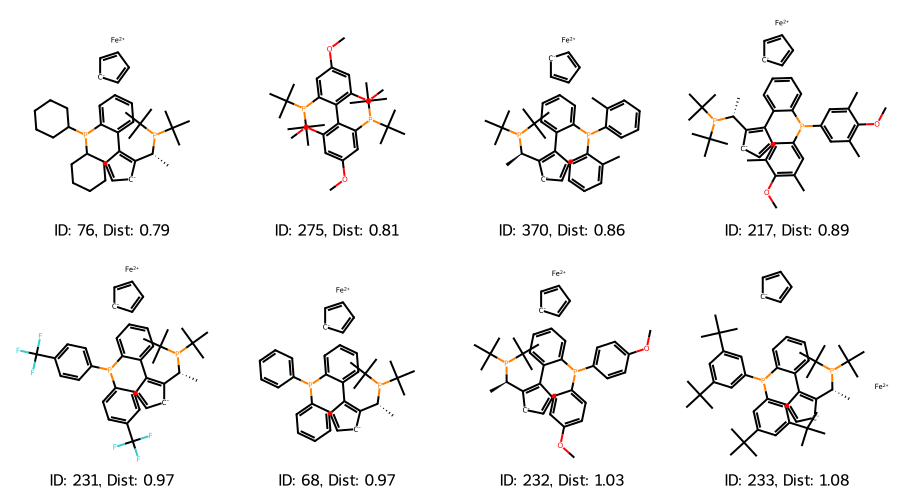

In [14]:
smiles_df = pd.read_csv('./ligand_selection/bident_smiles.csv')
smiles_df = smiles_df.set_index('id')
smiles_df.index = smiles_df.index.astype(int)

show_n_mols = 10    # Show up to N molecules nearest to the cluster center
cluster_select = 24
 # which cluster to inspect

def generate_molimg(show_n_mols,clusters_select):
    show_n_mols = int(show_n_mols)
    clustermin_idx = clustermins[clusters_select]
    sorted_mols = data_df.loc[data_df["cluster"] == clusters_select].sort_values(by="distance_to_center")
    showno = min(show_n_mols,len(sorted_mols))

    show_idxs = sorted_mols.iloc[:showno].index.tolist()
    namesobs = features.loc[show_idxs, "name"]
    print("Names:", namesobs)
    # Filter out indices that are not in smiles_df,since smiles_df doesnt contain smiles for all the Ls.
    valid_idxs = [idx for idx in show_idxs if idx in smiles_df.index]
    
    if not valid_idxs:
        print("No valid molecules found.")
        return None
    
    smilesobs = smiles_df.loc[valid_idxs, "smiles"]
    print("SMILES:", smilesobs)

    molobs = [Chem.MolFromSmiles(i) for i in smilesobs]
    legends = [f"ID: {i}, Dist: {data_df.loc[i,'distance_to_center']:.2f}" for i in valid_idxs]
    img_src = Draw.MolsToGridImage(molobs, subImgSize=(225,250), molsPerRow=4, legends = legends)
    
    return(img_src)

generate_molimg(show_n_mols,cluster_select)

We manually inspect each cluster and select ligands, starting from the one closest to the centroid, that are available for purchase from reputable vendors. The compiled list of monodentate ligands is available at `multicat-data/Pd_coupling/ligand_selection/bidentate_curated_scifinder.csv`. 

72 ligands were received successfully. The final list of ligands employed in the screen is available at `multicat-data/Pd_coupling/ligand_selection/purchased_ligand_list_master.csv`

[19:48:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5


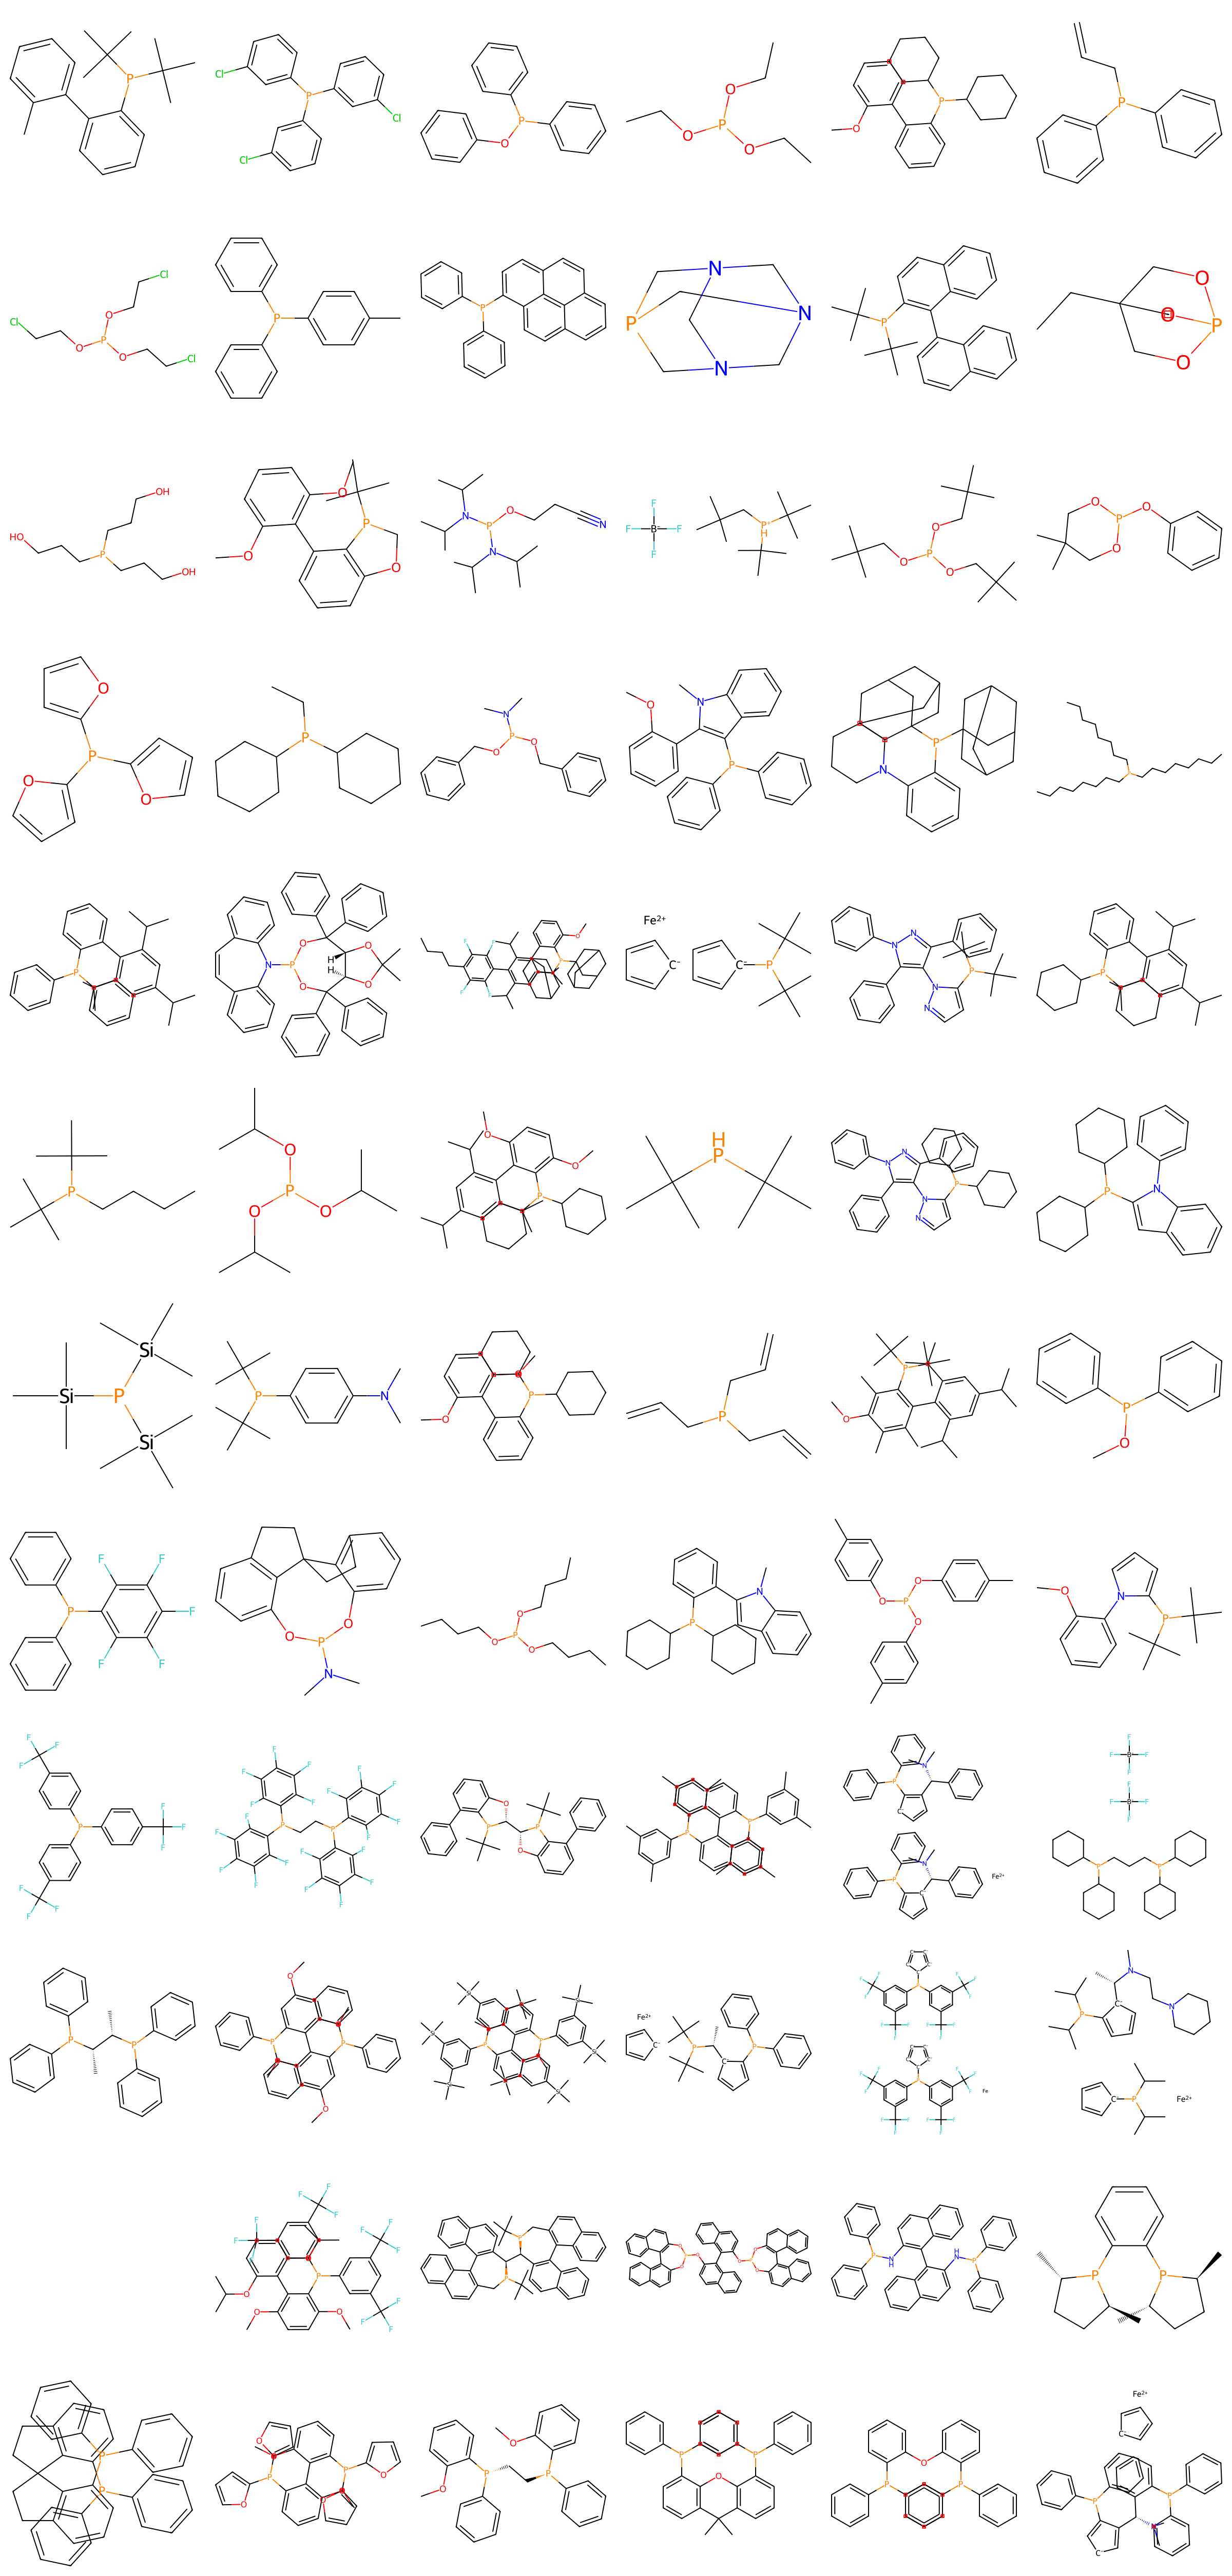

In [15]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
from io import BytesIO
import math

def DrawMolsZoomed(mols, molsPerRow=6, subImgSize=(400, 400), rowSpacing=20):
    nMols = len(mols)
    nRows = math.ceil(nMols / molsPerRow)
    # Add spacing between rows (but not after the last row)
    fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1] + (nRows - 1) * rowSpacing)
    full_image = Image.new('RGBA', fullSize, (255, 255, 255, 255))
    
    for ii, mol in enumerate(mols):
        if mol is None:
            continue
        if mol.GetNumConformers() == 0:
            AllChem.Compute2DCoords(mol)
        
        # Draw molecule independently
        d2d = rdMolDraw2D.MolDraw2DCairo(subImgSize[0], subImgSize[1])
        d2d.drawOptions().padding = 0.05
        d2d.DrawMolecule(mol)
        d2d.FinishDrawing()
        
        sub_img = Image.open(BytesIO(d2d.GetDrawingText()))
        
        # Paste into grid with row spacing
        col = ii % molsPerRow
        row = ii // molsPerRow
        offset = (col * subImgSize[0], row * (subImgSize[1] + rowSpacing))
        full_image.paste(sub_img, box=offset)

    return full_image

# Load the CSV file
ligands_df = pd.read_csv('./ligand_selection/purchased_ligand_list_master.csv')
# Prepare molecules
molobs = [Chem.MolFromSmiles(str(sm)) for sm in ligands_df['smiles'][:72]]

# Draw with independent scaling and row spacing
img = DrawMolsZoomed(molobs, molsPerRow=6, subImgSize=(400, 400), rowSpacing=20)
display(img)

## Experimental data

Pooling and deconvolution were performed with the [Multicat website](https://multicat.onrender.com). The relevant CSV "worksheets" with yields filled in are included in `multicat-data/Pd_coupling/experiment`.

The single catalyst yields of the biaryl (**6a**) and ketone (**7a**) products are available in `multicat-data/Pd_coupling/experiment/single_lig_biaryl_yield.csv` and `multicat-data/Pd_coupling/experiment/single_lig_ketone_yield.csv` respectively. The results for the 10 randomly selected ligands for repeats are available in `multicat-data/Pd_coupling/experiment/single_lig_repeats_biaryl_yield.csv`.

In [16]:
def plot_output_correlation(csv1_path, csv2_path):
    """
    Plot correlation between output values from two CSV files, matched by cat column.
    
    Parameters:
    csv1_path (str): Path to first CSV file (superset, contains cat and output columns)
    csv2_path (str): Path to second CSV file (subset, contains cat and output columns)
    
    Returns:
    pandas.DataFrame: Merged dataframe with matched records
    """
    
    try:
        # Read the CSV files
        df1 = pd.read_csv(csv1_path)
        df2 = pd.read_csv(csv2_path)
        
        # Clean the cat columns to remove brackets
        df1['cat_clean'] = df1['cat'].astype(str).str.strip('[]').astype(int)
        df2['cat_clean'] = df2['cat'].astype(str).str.strip('[]').astype(int)
        
        # Merge the dataframes on cleaned cat column
        merged_df = pd.merge(df1[['cat_clean', 'output']], 
                           df2[['cat_clean', 'output']], 
                           on='cat_clean', 
                           suffixes=('_csv1', '_csv2'),
                           how='inner')
        
        if merged_df.empty:
            print("Warning: No matching records found between the two CSV files")
            return merged_df
        
        # Calculate correlation
        correlation = merged_df['output_csv1'].corr(merged_df['output_csv2'])
        
        # Create the scatter plot
        plt.figure(figsize=(8, 6), dpi=300)
        plt.scatter(merged_df['output_csv1'], merged_df['output_csv2'], 
                   alpha=0.7, s=60, color='steelblue', 
                   edgecolors='black', linewidth=0.5)
        
        # Add labels for each point with cat values
        for i, row in merged_df.iterrows():
            plt.annotate(f"{int(row['cat_clean'])}", 
                        (row['output_csv1'], row['output_csv2']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=9, alpha=0.8, fontweight='bold')
        
        # Add diagonal line for perfect correlation (now using 0-100 range)
        # Add diagonal line for perfect correlation and ±5% envelope
        x_line = [0, 50]
        y_line = [0, 50]
        plt.plot(x_line, y_line, 'r--', alpha=0.7, label='Perfect correlation', linewidth=2)
                
        # Set axis limits to 0-100
        plt.xlim(0, 50)
        plt.ylim(0, 50)
        
        plt.xlabel('biaryl yield (%), rep 1', fontsize=12)
        plt.ylabel('biaryl yield (%), rep 2', fontsize=12)
        plt.title(f'Correlation between repeats', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Print summary information
        print(f"Successfully matched {len(merged_df)} records")
        print(f"Correlation coefficient: {correlation:.4f}")
        print(f"Cat values matched: {sorted(merged_df['cat_clean'].tolist())}")
        
        return merged_df
        
    except FileNotFoundError as e:
        print(f"Error: Could not find file - {e}")
        return None
    except Exception as e:
        print(f"Error: {e}")
        return None

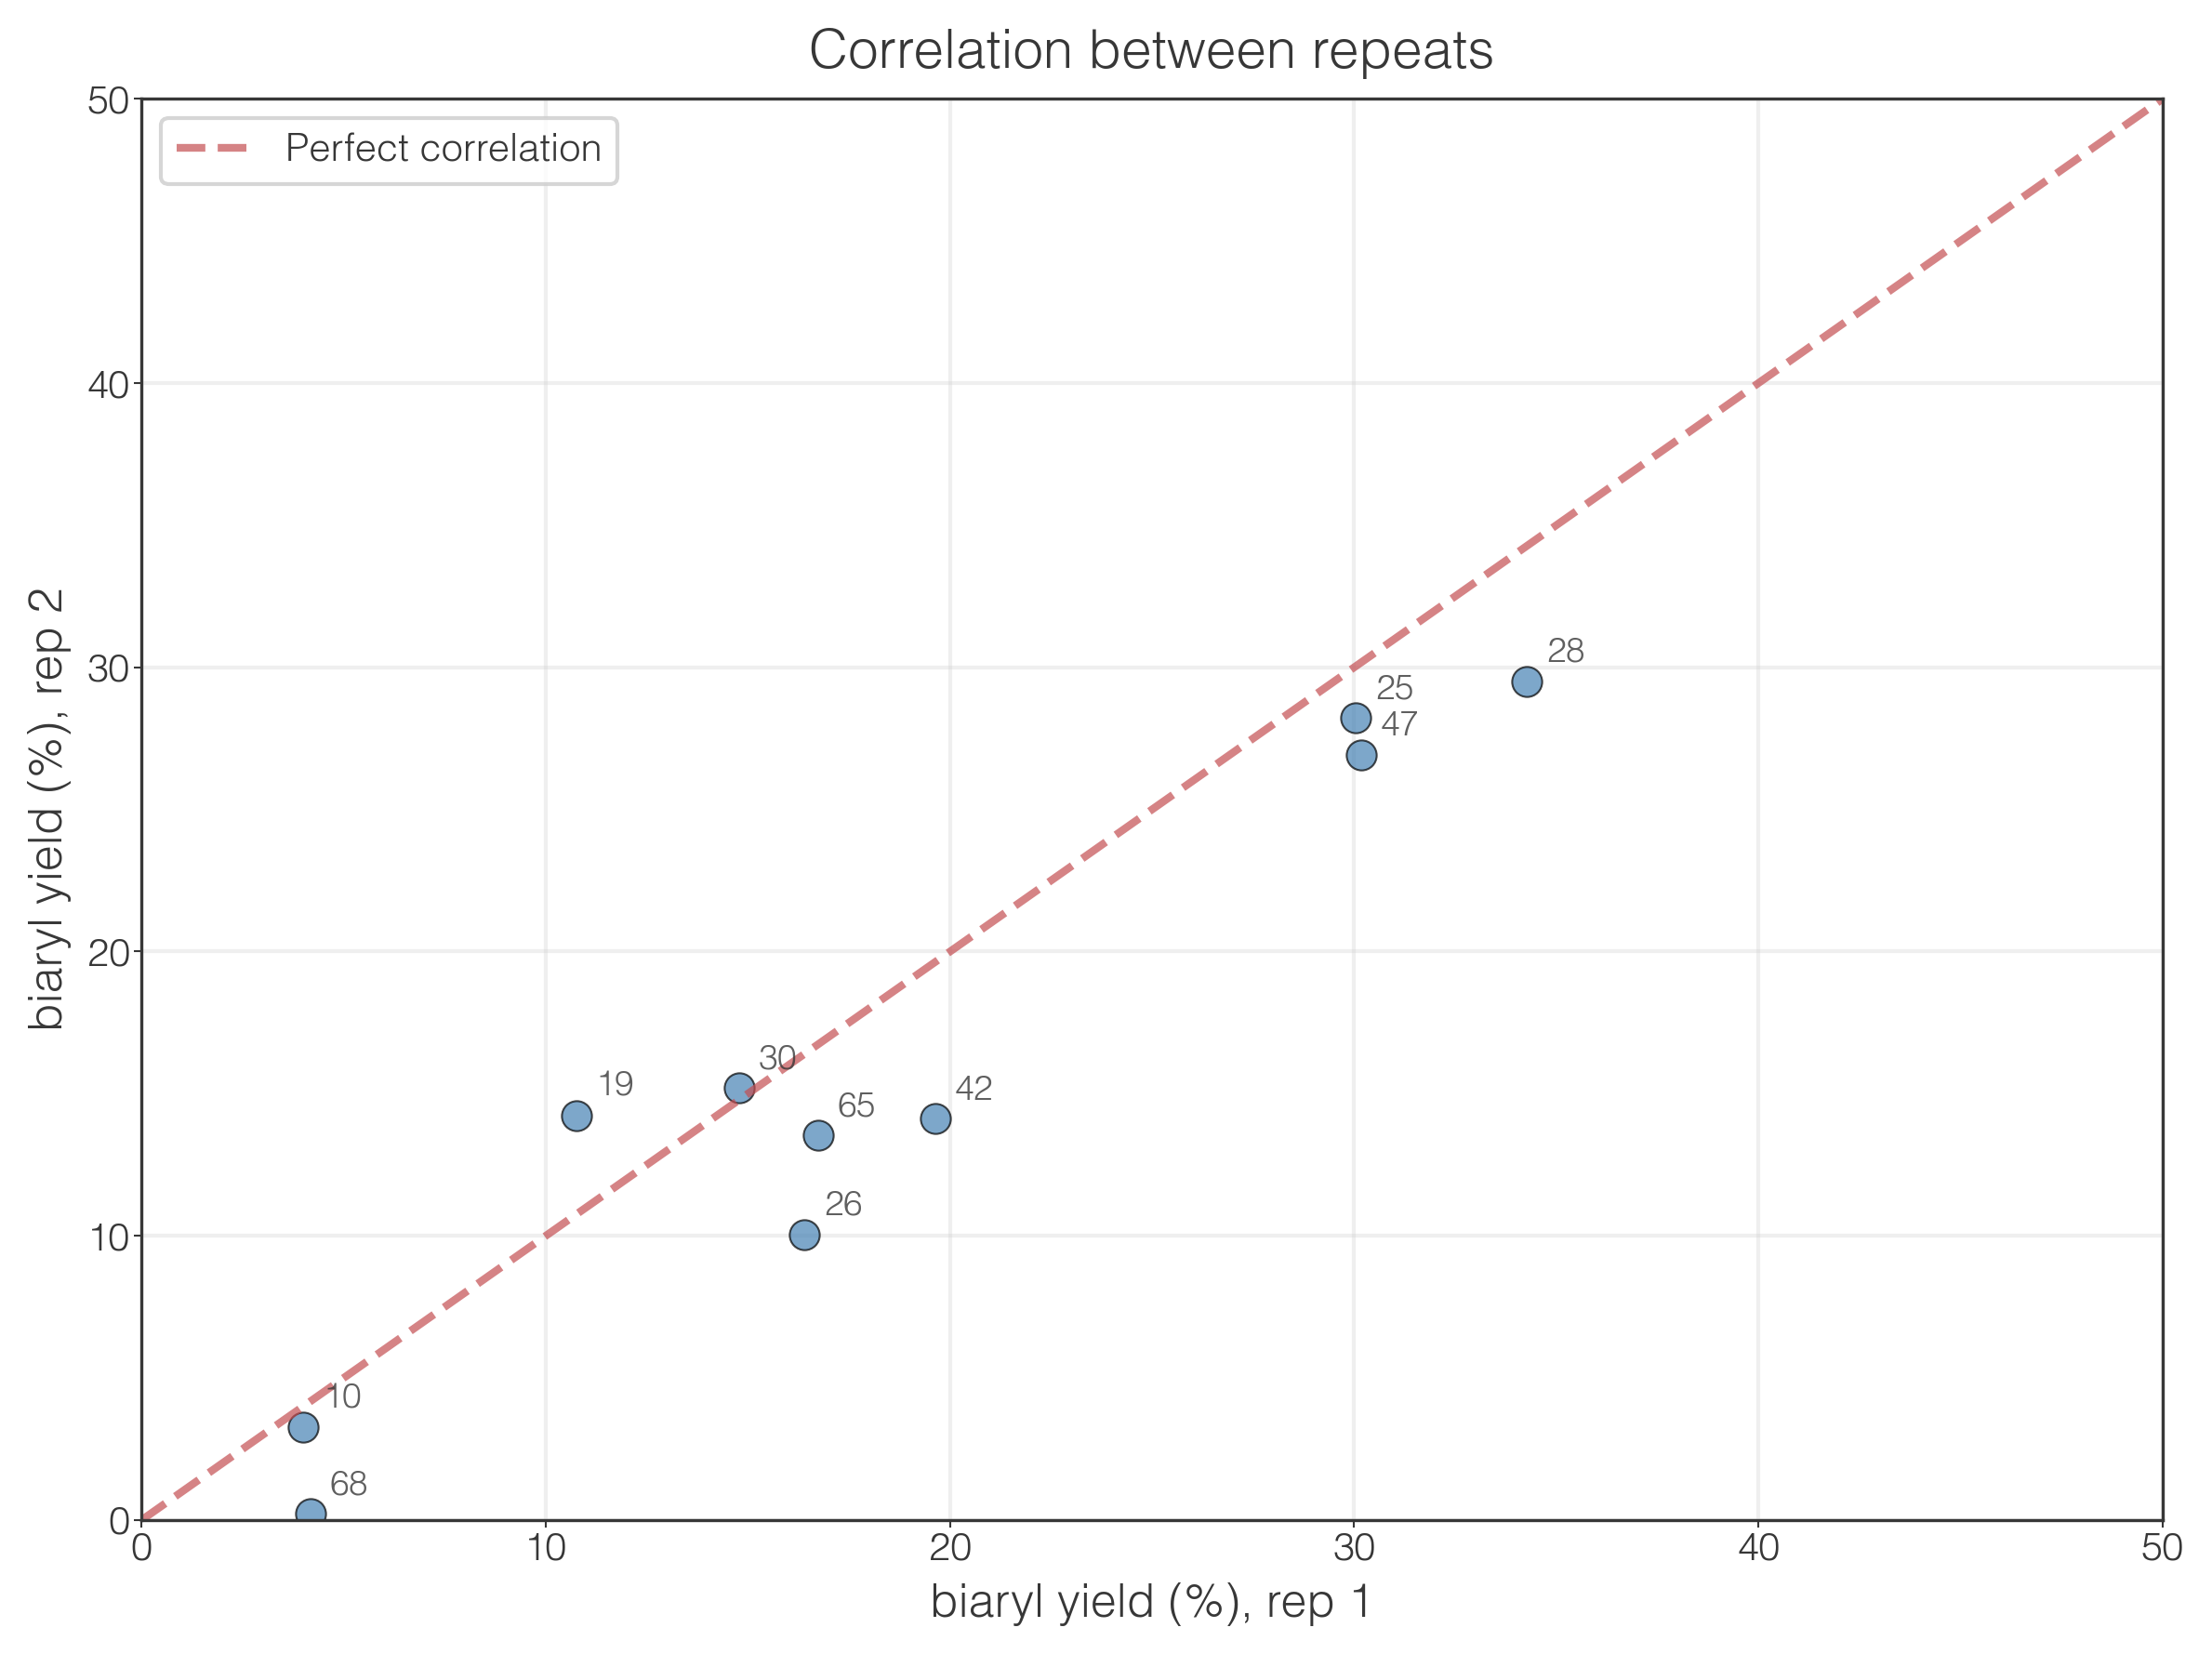

Successfully matched 10 records
Correlation coefficient: 0.9598
Cat values matched: [10, 19, 25, 26, 28, 30, 42, 47, 65, 68]


,cat_clean,output_csv1,output_csv2
0,10,3.997058,3.256235
1,19,10.753697,14.240400
2,25,30.046170,28.218664
3,26,16.393647,10.049753
4,28,34.266644,29.512809
5,30,14.779495,15.210584
6,42,19.641993,14.111462
7,47,30.161735,26.907595
8,65,16.736834,13.534609
9,68,4.166919,0.216659


In [17]:
yield1 = './experiment/single_lig_biaryl_yield.csv'
yield2 = './experiment/single_lig_repeats_biaryl_yield.csv'

plot_output_correlation(yield1, yield2)

Pooling and deconvolution were performed with the [Multicat website](https://multicat.onrender.com). The pool design and yields are available in `multicat-data/Pd_coupling/experiment/pools_biaryl_yield.csv`. The $ Q_\text{deconv} $ scores of all pairs are available in `multicat-data/Pd_coupling/experiment/Q_deconv_all_pairs_rel_singles_max.csv`. The yields and $ Q $ scores of the top-48 and 37 random pairs are available in `multicat-data/Pd_coupling/experiment/top_48_pairs_yield_Q` and `multicat-data/Pd_coupling/experiment/random_37_pairs_yield_Q.csv`.

In [20]:
# Load the CSV files the user uploaded
top = pd.read_csv("./experiment/top_48_pairs_yield_Q.csv")
rem = pd.read_csv("./experiment/random_37_pairs_yield_Q.csv")

# Ensure the 'score' column is numeric and drop any non‑numeric rows
top_scores = pd.to_numeric(top["score"], errors="coerce").dropna()
rem_scores = pd.to_numeric(rem["score"], errors="coerce").dropna()

# -------------------------------
# Descriptive statistics
# -------------------------------
summary = pd.DataFrame({
    "Population": ["Top 48", "Remaining 37"],
    "N": [len(top_scores), len(rem_scores)],
    "Mean": [top_scores.mean(), rem_scores.mean()],
    "Median": [top_scores.median(), rem_scores.median()],
    "Std Dev": [top_scores.std(ddof=1), rem_scores.std(ddof=1)]
})

print("### Descriptive Statistics\n")
print(summary.to_string(index=False))

# -------------------------------
# Outlier enrichment analysis
#    (Tukey criterion: Q3 + 1.5 × IQR)
# -------------------------------
combined = pd.concat([top_scores, rem_scores])
q1, q3 = combined.quantile(0.25), combined.quantile(0.75)
iqr = q3 - q1
threshold = q3 + 1.5 * iqr

top_outliers = (top_scores > threshold).sum()
rem_outliers = (rem_scores > threshold).sum()
table = [[top_outliers, len(top_scores) - top_outliers],
         [rem_outliers, len(rem_scores) - rem_outliers]]
oddsratio, fisher_p = stats.fisher_exact(table, alternative="greater")

print("\n### Outlier Analysis\n")
print(f"Outlier threshold (Q3 + 1.5 × IQR): {threshold:.3f}")
print(f"Top 48:        {top_outliers}/{len(top_scores)}  ({top_outliers/len(top_scores):.2%})")
print(f"Remaining 37:  {rem_outliers}/{len(rem_scores)}  ({rem_outliers/len(rem_scores):.2%})")
print(f"Fisher’s exact test (greater): p = {fisher_p:.4f}")

### Descriptive Statistics

  Population  N     Mean  Median  Std Dev
      Top 48 48 0.765042  0.3705 1.572569
Remaining 37 37 0.240838  0.2350 0.530308

### Outlier Analysis

Outlier threshold (Q3 + 1.5 × IQR): 2.140
Top 48:        5/48  (10.42%)
Remaining 37:  0/37  (0.00%)
Fisher’s exact test (greater): p = 0.0522
